In [1]:
import glob
import charts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

The goal of our exploration is to find patterns in our data and find ways to manipulate our data so that our model can make better predictions.

In [2]:
#**IMPORTING DATA**
files=glob.glob('../../data/price_index_data/mod/*')

#getting the prices history from each index
data=[]
for file in files:
    data.append(pd.read_csv(file))

#converting the 'date' columns to datetime type
for i in data:
    i['date']=pd.to_datetime(i['date'])

#combining the data together
df=data[0]
for i in data[1:]:
    df=df.merge(i,on='date')

#removing the date column and setting it as the index
df.index=df['date']
df.drop(columns=['date'],inplace=True)

#removing unecessary columns
cols=[i for i in list(df.columns) if 'Unnamed' not in i]
df=df[cols]
df=df.dropna()

Now that we have our data, lets take a look at a portion of it to see what it looks like. 

In [3]:
df.head()

,bit_open,bit_close,nas_open,nas_close,eth_open,eth_close,dow_open,dow_close,ada_open,ada_close,amd_open,amd_close,snp_open,snp_close,bnb_open,bnb_close,nvda_open,nvda_close
date,,,,,,,,,,,,,,,,,,
2017-10-02,4414.17750,4424.47250,6506.08,6516.72,300.582000,300.062000,22423.47,22557.60,0.024607,0.025932,12.80,12.71,2520.6,2526.3,1.52662,1.96467,45.200001,44.750000
2017-10-03,4424.47250,4307.55500,6523.74,6531.71,299.994100,292.847181,22564.45,22641.67,0.025757,0.020816,12.73,13.42,2526.5,2532.8,1.96783,1.82070,44.812500,44.842499
2017-10-04,4307.55500,4186.78374,6521.96,6534.63,292.806751,289.300806,22645.67,22661.64,0.020864,0.021931,13.31,13.31,2531.5,2536.2,1.85150,1.60148,44.904999,45.217499
2017-10-05,4186.78374,4325.23625,6552.87,6585.36,289.682534,295.510772,22669.08,22775.39,0.021951,0.021489,13.38,13.34,2535.7,2549.9,1.63499,1.67849,45.465000,45.192501
2017-10-06,4325.23625,4370.16875,6566.95,6590.18,296.049000,309.599509,22762.03,22773.67,0.021359,0.018539,13.22,13.23,2548.6,2545.1,1.67731,1.57991,44.912498,45.325001


We have lots of data which is a good thing! The open prices and close price for each index are very close to each other. We can probably drop one of them to make our analysis easier.

In [4]:
df.corr()

,bit_open,bit_close,nas_open,nas_close,eth_open,eth_close,dow_open,dow_close,ada_open,ada_close,amd_open,amd_close,snp_open,snp_close,bnb_open,bnb_close,nvda_open,nvda_close
bit_open,1.000000,0.998201,0.856451,0.855794,0.896407,0.897802,0.853874,0.854632,0.850133,0.852492,0.724955,0.723352,0.865583,0.866384,0.885518,0.889578,0.800188,0.800234
bit_close,0.998201,1.000000,0.857093,0.856740,0.891488,0.895779,0.852273,0.853654,0.845057,0.850133,0.726996,0.725530,0.864807,0.865982,0.879390,0.886461,0.800100,0.800436
nas_open,0.856451,0.857093,1.000000,0.999264,0.772212,0.773543,0.922690,0.921973,0.732452,0.734711,0.952960,0.952270,0.977917,0.977995,0.760965,0.764016,0.954127,0.953488
nas_close,0.855794,0.856740,0.999264,1.000000,0.771839,0.773395,0.921570,0.922847,0.732405,0.734955,0.952825,0.953144,0.977143,0.978648,0.760465,0.763687,0.953667,0.954195
eth_open,0.896407,0.891488,0.772212,0.771839,1.000000,0.997255,0.812075,0.811549,0.962444,0.961578,0.607442,0.606718,0.815109,0.814695,0.927659,0.924890,0.803177,0.803834
eth_close,0.897802,0.895779,0.773543,0.773395,0.997255,1.000000,0.811956,0.812103,0.958959,0.962213,0.609964,0.609305,0.815653,0.815667,0.927215,0.928527,0.803587,0.804406
dow_open,0.853874,0.852273,0.922690,0.921570,0.812075,0.811956,1.000000,0.997274,0.786478,0.787709,0.816724,0.816517,0.977823,0.976390,0.819200,0.820233,0.848020,0.847615
dow_close,0.854632,0.853654,0.921973,0.922847,0.811549,0.812103,0.997274,1.000000,0.785906,0.787738,0.816435,0.817152,0.975768,0.977881,0.819185,0.820681,0.847111,0.847857
ada_open,0.850133,0.845057,0.732452,0.732405,0.962444,0.958959,0.786478,0.785906,1.000000,0.995826,0.576536,0.576104,0.785284,0.785342,0.906035,0.902967,0.777408,0.778957
ada_close,0.852492,0.850133,0.734711,0.734955,0.961578,0.962213,0.787709,0.787738,0.995826,1.000000,0.579797,0.579609,0.787068,0.787381,0.905442,0.907226,0.778588,0.780482


Looking at the correlation matrix above, we can see that the open price usually explains at least 99% of the close price variance for each index which means that having both variables in our data is redundant, so I will only look at the close price for analysis

In [5]:
cols=[i for i in df.columns if 'close' in i]
df=df[cols]

In [6]:
df.corr()

,bit_close,nas_close,eth_close,dow_close,ada_close,amd_close,snp_close,bnb_close,nvda_close
bit_close,1.000000,0.856740,0.895779,0.853654,0.850133,0.725530,0.865982,0.886461,0.800436
nas_close,0.856740,1.000000,0.773395,0.922847,0.734955,0.953144,0.978648,0.763687,0.954195
eth_close,0.895779,0.773395,1.000000,0.812103,0.962213,0.609305,0.815667,0.928527,0.804406
dow_close,0.853654,0.922847,0.812103,1.000000,0.787738,0.817152,0.977881,0.820681,0.847857
ada_close,0.850133,0.734955,0.962213,0.787738,1.000000,0.579609,0.787381,0.907226,0.780482
amd_close,0.725530,0.953144,0.609305,0.817152,0.579609,1.000000,0.903676,0.616859,0.901051
snp_close,0.865982,0.978648,0.815667,0.977881,0.787381,0.903676,1.000000,0.815545,0.924271
bnb_close,0.886461,0.763687,0.928527,0.820681,0.907226,0.616859,0.815545,1.000000,0.751110
nvda_close,0.800436,0.954195,0.804406,0.847857,0.780482,0.901051,0.924271,0.751110,1.000000


There is high correlation between the different price indexes which means that we have plenty of variables we can use for the linear model. The goal of this project is to predict the four cryptocurrency prices in the data so in the diagram below, I plot the other price indexes against the four cryptocurrency prices. To be more specific, for each cryptocurrency, I plot it against it against the variables it is linearly correlated with since we are looking for linear relationship right now.

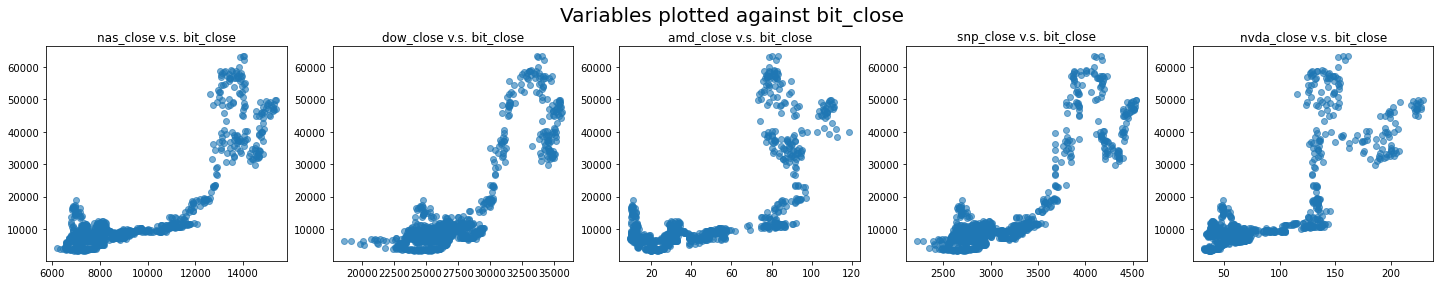

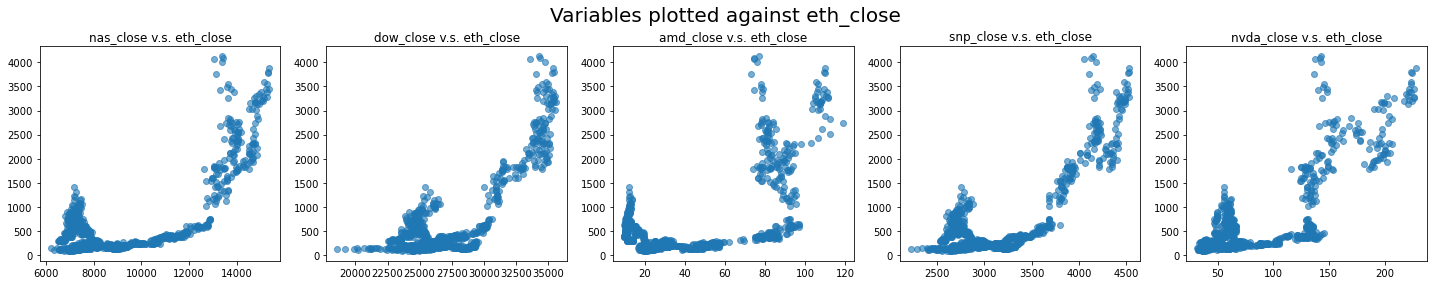

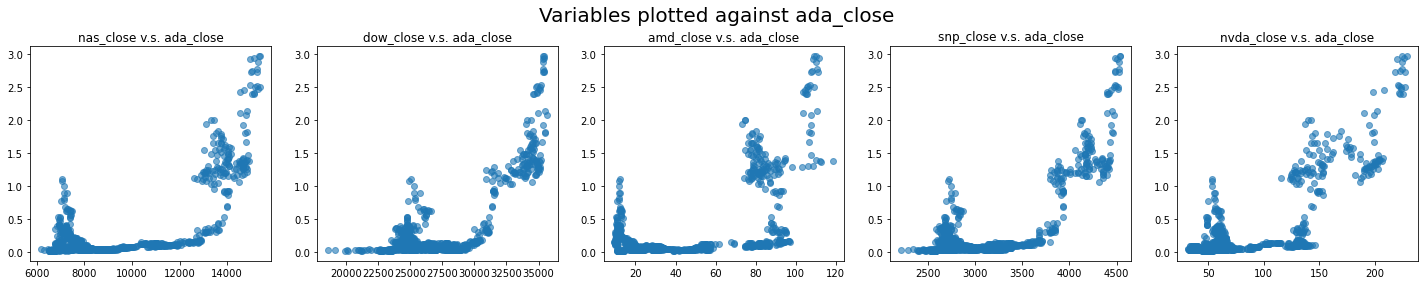

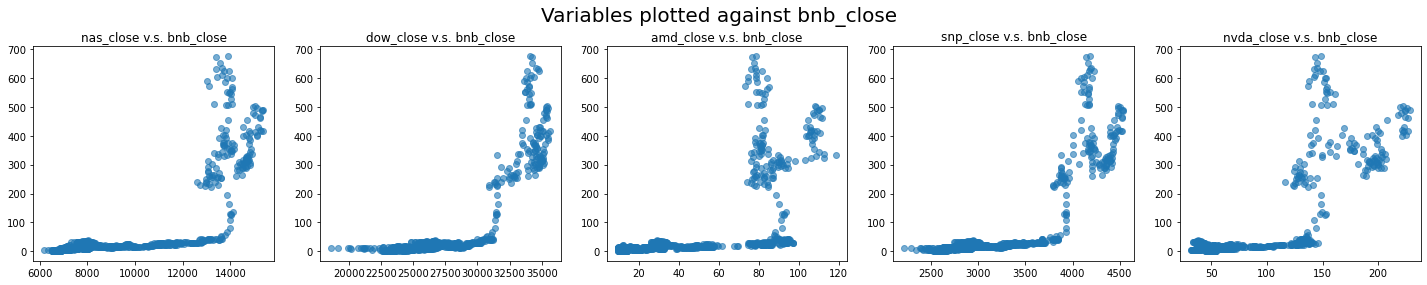

In [7]:
charts.plot_linear_relationships(df)

The relationships between the variables and the cryptocurrency prices aren't exactly linear, but they aren't completely random so there is a chance to improve the linear relationships with some feature engineering. The one thing that a price index is most correlated with is itself. We saw that earlier when looking at the correlation of the open and close price for each index. In the graphs below, I look at autocorrelation and partial autocorrelation of each variable to see how correlated the indexes are with themselves. These auto correlations will be useful for the models we will develop later.

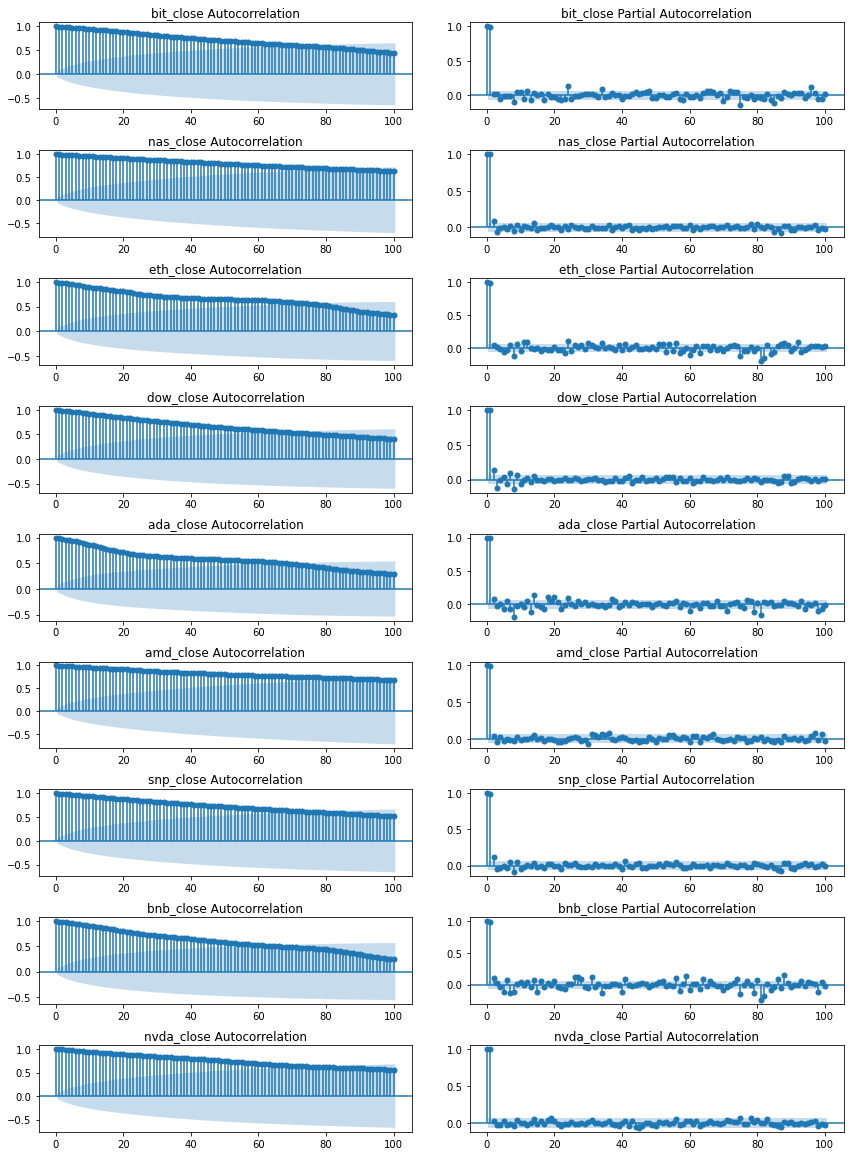

In [8]:
charts.ac_pac(df,lags=100)

There is a lot of auto correlation for each index so including a few different lags can help the performance of our models

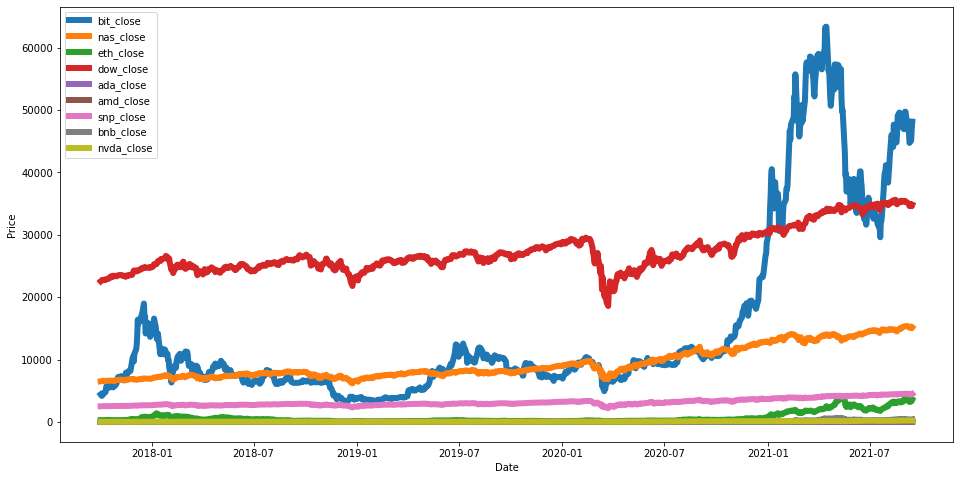

In [9]:
charts.plot_indexes(df)

Looking at the charts above, none of our data is stationary so I will have to deal with this in order to use the ARIMA models

In [10]:
df_sc=df-df.min()
df_sc/=df_sc.max()

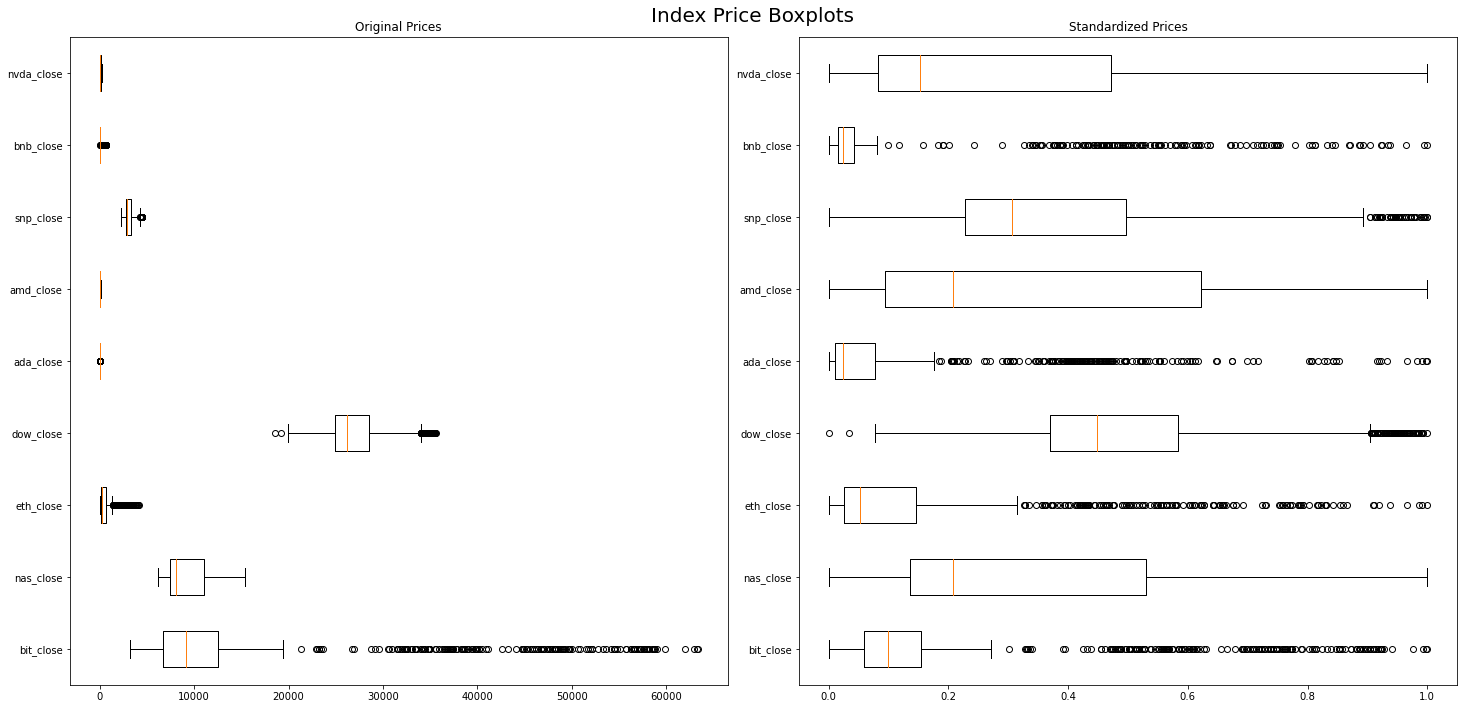

In [11]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
fig.suptitle(t=f'Index Price Boxplots ', size=20)
fig.tight_layout(h_pad=4, w_pad=4)
ax[0].set_title('Original Prices')
ax[0].boxplot(df, labels=df.columns,vert = 0)
ax[1].set_title('Standardized Prices')
a=ax[1].boxplot(df_sc, labels=df.columns,vert = 0)

Looking at the boxplots above, the outliers in cryptocurrecy prices will pose a challenge for predcition because they will effect how the models learns. I will try to fix this while I'm feature enginnering.

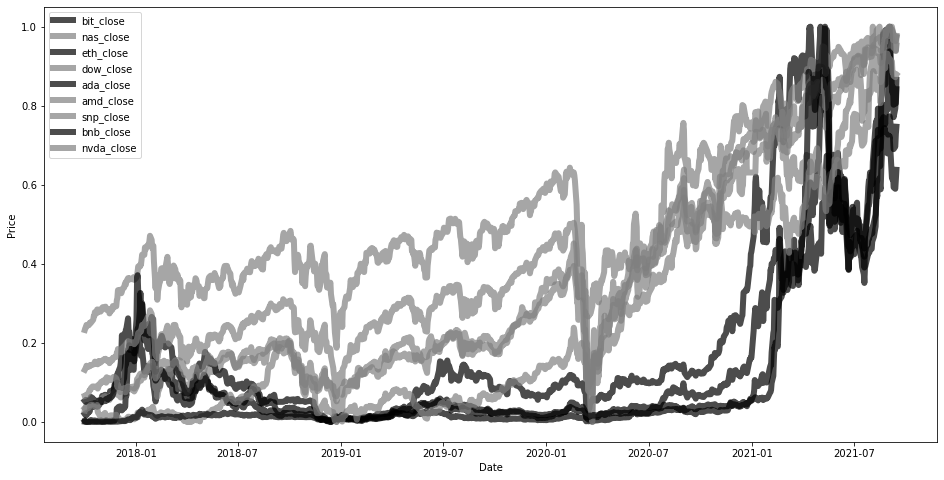

In [25]:
plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.ylabel('Price')
for i in df.columns:
    if i in ['bit_close', 'eth_close',  'ada_close', 'bnb_close']:
        plt.plot(df.index,df_sc[i],label=i,linewidth=6,color='black',alpha=0.7)
    else:
        plt.plot(df.index,df_sc[i],label=i,linewidth=6,color='grey',alpha=0.7)
    plt.legend()

In [13]:
df.columns

Index(['bit_close', 'nas_close', 'eth_close', 'dow_close', 'ada_close',
       'amd_close', 'snp_close', 'bnb_close', 'nvda_close'],
      dtype='object')

In [ ]:
['bit_close', 'eth_close',  'ada_close', 'bnb_close']